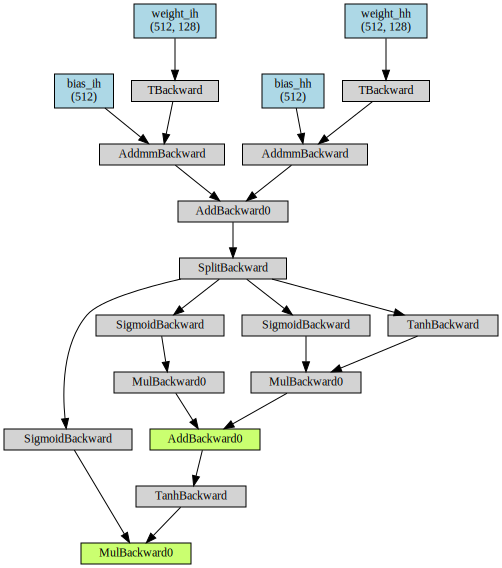

In [9]:
import torch.nn as nn
import torch
from torchviz import make_dot
lstm_cell = nn.LSTMCell(128, 128)
x = torch.randn(1, 128)
make_dot(lstm_cell(x), params=dict(list(lstm_cell.named_parameters())))

In [4]:
# a batch implementation of basic RNN model
# vocab is filtered based on the frequency of words... only use words with frequency at least 5 ... replace others with unk token
# pre-trained embeddings not used...
# embeddings learnt on the go...

from torch.utils import data
from torch.nn.utils import rnn
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import preprocess as pp
import numpy as np

from nltk import word_tokenize
import pickle

import tensorwatch as tw
from torchviz import make_dot
from pathlib import Path
#data_dir = Path.home() / 'GenderPerformance/datasets/reddit'
data_dir = Path.home() / 'GenderPerformance/datasets/yelp'

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

class Dataset(data.Dataset):
    def __init__(self, reviews, labels, lengths):
        self.reviews = reviews
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,index):
        X = torch.tensor(self.reviews[index],dtype=torch.long)
        y = torch.tensor(self.labels[index],dtype=torch.long)
        s_lengths = self.lengths[index]
        return X,y,s_lengths


class Encoder(nn.Module):
    def __init__(self, input_size, encoding_size, hidden_size, output_size, layers, padding_idx):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.encoding_size = encoding_size
        self.layers = layers
        self.embedding = nn.Embedding(input_size, encoding_size, padding_idx=padding_idx)
        self.e2i = nn.Linear(encoding_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=self.layers)
        self.dense1 = nn.Linear(hidden_size,hidden_size)
        self.dense2 = nn.Linear(hidden_size,hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.batch_first = True

    def forward(self, X, X_lengths, batch_size):

        self.hidden = self.initHidden(batch_size)
        X = self.embedding(X)
        X = self.e2i(X)
        X = rnn.pack_padded_sequence(X, X_lengths, batch_first=True)

        X, self.hidden = self.gru(X, self.hidden)

        X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

        idx = (torch.cuda.LongTensor(X_lengths) - 1).view(-1, 1).expand(len(X_lengths), X.size(2))

        time_dimension = 1 if self.batch_first else 0
        idx = idx.unsqueeze(time_dimension)
        X = X.gather(time_dimension, Variable(idx)).squeeze(time_dimension)

        X = self.dense1(X)
        X = self.dense2(X)
        X = self.out(X)
        X = self.sigmoid(X)

        return X

    def initHidden(self,batch_size):
         return torch.zeros(self.layers, batch_size, self.hidden_size).to(device)


def sortbylength(X,y,s_lengths):
    sorted_lengths, indices = torch.sort(s_lengths,descending=True)
    return X[torch.LongTensor(indices),:],y[torch.LongTensor(indices)],sorted_lengths


def ValidationAccuracy(encoder,dataset_validate,batch_size):
    loader_validate = data.DataLoader(dataset_validate,batch_size=batch_size)
    true_labels = []
    predicted_labels = []
    
    #with torch.no_grad():
    for X,y,X_lengths in loader_validate:
        X,y,X_lengths = sortbylength(X,y,X_lengths)
        X,y,X_lengths = X.to(device),y.to(device),X_lengths.to(device)
        b_size = y.size(0)
        output = encoder(X,X_lengths,b_size)
        output = F.softmax(output,dim=1)
        value,labels = torch.max(output,1)

        true_labels+=y.cpu().numpy().tolist()
        predicted_labels+=labels.cpu().numpy().tolist()
    
    print(confusion_matrix(true_labels, predicted_labels))
    return accuracy_score(true_labels, predicted_labels)



def train(encoder, dataset_train, dataset_validate, batch_size, saveas = '', epochs=10, learning_rate=0.001):
    optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss() # cross entropy loss in pytorch combines logsoftmax and negativeloglikelihoodloss...softmax layer not needed
    validation_accuracy = 0
    for i in range(epochs):
        batch_cnt = 0
        loader_train = data.DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
        for X,y,X_lengths in loader_train:
            batch_cnt+=1
            X,y,X_lengths = sortbylength(X,y,X_lengths)
            X,y,X_lengths = X.to(device),y.to(device),X_lengths.to(device)
            b_size = y.size(0)
            output = encoder(X,X_lengths,b_size)
#             tw.draw_model(output, [1, 3, 224, 224])
            print(output.requires_grad)
            make_dot(output)
            assert False
            loss = criterion(output,y)
            if batch_cnt%100==0:
                print('epoch - {}, batch count - {}, loss - {}'.format(i, batch_cnt, loss))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        accuracy = ValidationAccuracy(encoder,dataset_validate,batch_size)
        print('accuracy: {} at epoch: {}'.format(accuracy,i))
        if validation_accuracy < accuracy:
            validation_accuracy = accuracy
            torch.save(encoder.state_dict(), saveas)



def sentence2tensor(sentence,w2i,pad,sent_length):
    S = [w2i[w] for w in sentence]
    if len(S)>sent_length:
        return S[:sent_length]
    else:
        x = len(S)
        S = S + [pad for i in range(sent_length - x)]
        return S


def encodeDataset(fname,w2i,padding_idx,sent_length):
    reviews = []
    labels = []
    lengths = []
    count = 0

    filtered_fname = fname.with_name(fname.name + '_filtered')
    with open(filtered_fname) as fs:    
         for line in fs:
             count+=1
             label = line[0]
             review = line[2:]
             #words = review.strip().replace('.','').split()
             words = word_tokenize(review.strip())
             words = [w for w in words if w.isalpha()]
             if len(words)>0:
                reviews.append(sentence2tensor(words,w2i,padding_idx,sent_length))
                if len(words)>sent_length:
                    lengths.append(sent_length)
                else:
                    lengths.append(len(words))
                labels.append(int(label))
                if count%100000==0:
                    print('Encoded reviews: ',count)
                    break;

    return reviews,labels,lengths


if __name__=='__main__':

    sent_length = 100
    train_file_path = data_dir / 'training_gender_text.csv'
    validation_file_path = data_dir / 'validation_gender_text.csv'
    with open(data_dir / 'word2index.pickle','rb') as fs:
        w2i = pickle.load(fs)

    print('loaded vocabulary')
    print('size of vocabulary: ', len(w2i))

    vocab_size = len(w2i)
    padding_idx = 0 

    reviews_train,labels_train,lengths_train = encodeDataset(train_file_path,w2i,padding_idx,sent_length)
    reviews_validate, labels_validate, lengths_validate = encodeDataset(validation_file_path,w2i,padding_idx,sent_length)
    #reviews_test, labels_test, lengths_test = encodeDataset(test_file,w2i,padding_idx,sent_length)
    print('created batches from data loader')


    #print(reviews[2])
    dataset_train = Dataset(reviews_train,labels_train,lengths_train)
    dataset_validate = Dataset(reviews_validate,labels_validate,lengths_validate)
    encoding_size = 200

    hidden_size = 250
    input_size = vocab_size+1
    output_size = 2
    layers = 2
    batch_size = 256
    encoder = Encoder(input_size, encoding_size, hidden_size, output_size,layers, padding_idx)
#     tw.draw_model(encoder(X_lengths=32, batch_size=256), [1, 3, 224, 224])
    print(encoder)
    encoder = encoder.to(device)
    train(encoder,dataset_train, dataset_validate, batch_size, saveas=data_dir / 'RNN_vanilla_2_yafei.pt')



loaded vocabulary
size of vocabulary:  109619
Encoded reviews:  100000
Encoded reviews:  100000
created batches from data loader
Encoder(
  (embedding): Embedding(109620, 200, padding_idx=0)
  (e2i): Linear(in_features=200, out_features=250, bias=True)
  (gru): GRU(250, 250, num_layers=2, batch_first=True)
  (dense1): Linear(in_features=250, out_features=250, bias=True)
  (dense2): Linear(in_features=250, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)
True


AssertionError: 